In [13]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn import MTCNN
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(64, 64)):
	# detect face in the image
	faces = model.detect_faces(pixels)
	# skip cases where we could not detect a face
	if len(faces) == 0:
		return None
	# extract details of the face
	x1, y1, width, height = faces[0]['box']
	# force detected pixel values to be positive (bug fix)
	x1, y1 = abs(x1), abs(y1)
	# convert into coordinates
	x2, y2 = x1 + width, y1 + height
	# retrieve face pixels
	face_pixels = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face_pixels)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	# prepare model
	model = MTCNN()
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# get face
		face = extract_face(model, pixels)
		if face is None:
			continue
		# store
		faces.append(face)
		print(len(faces), face.shape)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return asarray(faces)


directory = './img_align_celeba/img_align_celeba/'

# load and extract all faces
all_faces = load_faces(directory, 50000)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('img_align_celeba60.npz', all_faces)

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [14]:
DATA_PATH = './img_align_celeba/img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image
MERGE_Y = BATCH_SIZE//MERGE_X

In [15]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'
from numpy import load
loaded_data = load('./img_align_celeba60.npz')
data = loaded_data['arr_0']
# convert from unsigned ints to floats
data = data.astype('float32')
# scale from [0,255] to [-1,1]
data = (data - 127.5) / 127.5

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [16]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    h_in_n = batch_norm(name='g_h1_norm')(h_in, is_training)
    h_0 = lrelu(h_in_n, name='g_h1_activation')
    
    conv2 = deconv2d(h_0, [BATCH_SIZE, 8, 8, 512],
                     name='g_h2_conv')
    conv2_n = batch_norm(name='g_h2_norm')(conv2, is_training)
    conv2_non_linear = lrelu(conv2_n, name='g_h2_activation')
    conv2_d = tf.nn.dropout(conv2_non_linear, 0.5, name='g_dr_2')
    
    conv3 = deconv2d(conv2_d, [BATCH_SIZE, 16, 16, 256],
                     name='g_h3_conv')
    conv3_n = batch_norm(name='g_h3_norm')(conv3, is_training)
    conv3_non_linear = lrelu(conv3_n, name='g_h3_activation')
    conv3_d = tf.nn.dropout(conv3_non_linear, 0.5, name='g_dr_3')
    
    conv4 = deconv2d(conv3_d, [BATCH_SIZE, 32, 32, 128],
                     name='g_h4_conv')
    conv4_n = batch_norm(name='g_h4_norm')(conv4, is_training) 
    
    h_prev = lrelu(conv4_n, name='g_h4_activation')
    h_prev_d = tf.nn.dropout(h_prev, 0.5, name='g_dr_4')
   
    h_out = deconv2d(h_prev_d, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [17]:
def discriminator(image, is_training, batch_norms=None):
    """
        Your code goes here.
    """
    conv1 = conv2d(image, 32,
                     name='d_h1_conv')
    conv1_n = batch_norm(name='d_h1_norm')(conv1, is_training)
    conv1_non_linear = lrelu(conv1_n, name='d_h1_activation')
    conv1_p = tf.layers.average_pooling2d(conv1_non_linear, pool_size=(2, 2), strides=2, name='d_pool_1')
    
    conv2 = conv2d(conv1_p, 64,
                     name='d_h2_conv')
    conv2_n = batch_norm(name='d_h2_norm')(conv2, is_training)
    conv2_non_linear = lrelu(conv2_n, name='d_h2_activation')
    conv2_p = tf.layers.average_pooling2d(conv2_non_linear, pool_size=(2, 2), strides=2, name='d_pool_2')
    
    conv3 = conv2d(conv2_p, 128,
                     name='d_h3_conv')
    conv3_n = batch_norm(name='d_h3_norm')(conv3, is_training)
    conv3_non_linear = lrelu(conv3_n, name='d_h3_activation')
    conv3_p = tf.layers.average_pooling2d(conv3_non_linear, pool_size=(2, 2), strides=2, name='d_pool_3')
   
    #
    flattened = tf.layers.flatten(conv3_p)
    dense1 = linear(flattened, 128, 'd_dense')
    dense1_a = lrelu(dense1, name='d_lr_dense')
    linear_out = linear(dense1_a, 1, 'linear_out')
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [ ]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    #batch_norms = [batch_norm(name='d_bn0'),batch_norm(name='d_bn1'),batch_norm(name='d_bn2'),batch_norm(name='d_bn3')]
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [19]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real  = -tf.reduce_mean(tf.math.log(D_real + tf.keras.backend.epsilon()))

d_loss_fake = -tf.reduce_mean(tf.math.log(1-D_fake + tf.keras.backend.epsilon()))

d_loss = -tf.reduce_mean(tf.math.log(1-D_fake + tf.keras.backend.epsilon()) + tf.math.log(D_real + tf.keras.backend.epsilon()))

g_loss = -tf.reduce_mean(tf.math.log(D_fake + tf.keras.backend.epsilon()))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [20]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

#### data = glob(os.path.join(DATA_PATH, "*.jpg"))
#assert(len(data) > 0), "Length of training data should be more than zero"


In [9]:
IMAGE_SIZE

64

Functions for training and evaluations.

In [21]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [89]:
def train(sess, load_dir='checkpoint', save_frequency=781, sample_frequency=781, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan-norm.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})
            counter += 1
            
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: [F:{:.4f}, R:{:.4f}], g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake, errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_Y],
                            os.path.join(sample_dir, 'train2_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [ ]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan-norm.model
Loaded checkpoints
Epoch: [ 0] [   0/ 781] time: 7.3623, d_loss: [F:0.4406, R:0.7087], g_loss: 1.22075200
Epoch: [ 0] [   1/ 781] time: 12.7159, d_loss: [F:0.4678, R:0.7510], g_loss: 1.14463913
Epoch: [ 0] [   2/ 781] time: 18.2333, d_loss: [F:0.3597, R:0.9685], g_loss: 1.44469690
Epoch: [ 0] [   3/ 781] time: 23.7432, d_loss: [F:0.4069, R:1.0512], g_loss: 1.33281887
Epoch: [ 0] [   4/ 781] time: 29.1500, d_loss: [F:0.5377, R:0.7052], g_loss: 1.08815515
Epoch: [ 0] [   5/ 781] time: 35.4127, d_loss: [F:0.5387, R:0.7660], g_loss: 1.20021522
Epoch: [ 0] [   6/ 781] time: 43.0368, d_loss: [F:0.5538, R:0.9387], g_loss: 1.48528814
Epoch: [ 0] [   7/ 781] time: 50.5361, d_loss: [F:0.5803, R:1.1660], g_loss: 1.27452219
Epoch: [ 0] [   8/ 781] time: 58.0419, d_loss: [F:0.2193, R:2.8770], g_loss: 3.16146564
Epoch: [ 0] [   9/ 781] time: 65.5447, d_loss: [F:0.2851, R:1.8285], g_loss: 2.01974964
Epoch: [ 

Epoch: [ 0] [  91/ 781] time: 678.5624, d_loss: [F:0.3193, R:1.0212], g_loss: 1.46575975
Epoch: [ 0] [  92/ 781] time: 686.0084, d_loss: [F:0.4552, R:0.7332], g_loss: 1.11673605
Epoch: [ 0] [  93/ 781] time: 693.4385, d_loss: [F:0.4675, R:0.4886], g_loss: 1.18620992
Epoch: [ 0] [  94/ 781] time: 700.9216, d_loss: [F:0.5355, R:0.6764], g_loss: 1.12238979
Epoch: [ 0] [  95/ 781] time: 708.3362, d_loss: [F:0.4853, R:0.8425], g_loss: 1.26342487
Epoch: [ 0] [  96/ 781] time: 715.7986, d_loss: [F:0.5419, R:0.5660], g_loss: 1.09532619
Epoch: [ 0] [  97/ 781] time: 723.3233, d_loss: [F:0.6066, R:0.3998], g_loss: 1.01660883
Epoch: [ 0] [  98/ 781] time: 730.9192, d_loss: [F:0.5707, R:0.6611], g_loss: 1.08436871
Epoch: [ 0] [  99/ 781] time: 738.4277, d_loss: [F:0.6351, R:0.6318], g_loss: 1.01071811
Epoch: [ 0] [ 100/ 781] time: 745.9140, d_loss: [F:0.5981, R:0.5263], g_loss: 0.98419619
Epoch: [ 0] [ 101/ 781] time: 753.3909, d_loss: [F:0.6288, R:0.3722], g_loss: 0.89822102
Epoch: [ 0] [ 102/ 78

Epoch: [ 0] [ 183/ 781] time: 1363.9825, d_loss: [F:0.4728, R:0.7889], g_loss: 1.18561316
Epoch: [ 0] [ 184/ 781] time: 1371.4327, d_loss: [F:0.5024, R:0.5666], g_loss: 1.17374074
Epoch: [ 0] [ 185/ 781] time: 1378.8461, d_loss: [F:0.4830, R:0.7738], g_loss: 1.26279497
Epoch: [ 0] [ 186/ 781] time: 1386.2743, d_loss: [F:0.4439, R:0.5668], g_loss: 1.28487074
Epoch: [ 0] [ 187/ 781] time: 1393.7052, d_loss: [F:0.4136, R:0.7463], g_loss: 1.24033666
Epoch: [ 0] [ 188/ 781] time: 1401.1565, d_loss: [F:0.5189, R:0.5979], g_loss: 1.12073398
Epoch: [ 0] [ 189/ 781] time: 1408.5808, d_loss: [F:0.5497, R:0.4083], g_loss: 0.94902480
Epoch: [ 0] [ 190/ 781] time: 1415.9798, d_loss: [F:0.4930, R:0.5348], g_loss: 1.07191360
Epoch: [ 0] [ 191/ 781] time: 1423.3948, d_loss: [F:0.6058, R:0.4167], g_loss: 0.85070980
Epoch: [ 0] [ 192/ 781] time: 1430.8586, d_loss: [F:0.4823, R:0.5703], g_loss: 1.14591753
Epoch: [ 0] [ 193/ 781] time: 1438.2756, d_loss: [F:0.5398, R:0.7214], g_loss: 1.14603949
Epoch: [ 0

Epoch: [ 0] [ 275/ 781] time: 2049.2280, d_loss: [F:0.5401, R:0.7292], g_loss: 1.16176260
Epoch: [ 0] [ 276/ 781] time: 2056.6626, d_loss: [F:0.6931, R:0.6804], g_loss: 0.99073327
Epoch: [ 0] [ 277/ 781] time: 2064.0746, d_loss: [F:0.4159, R:1.1208], g_loss: 1.44834507
Epoch: [ 0] [ 278/ 781] time: 2071.5130, d_loss: [F:0.5746, R:0.4287], g_loss: 0.98408914
Epoch: [ 0] [ 279/ 781] time: 2078.9586, d_loss: [F:0.5252, R:0.4007], g_loss: 1.08757269
Epoch: [ 0] [ 280/ 781] time: 2086.4567, d_loss: [F:0.3942, R:0.6900], g_loss: 1.46231377
Epoch: [ 0] [ 281/ 781] time: 2093.9562, d_loss: [F:0.4417, R:0.5999], g_loss: 1.26840568
Epoch: [ 0] [ 282/ 781] time: 2101.4085, d_loss: [F:0.4832, R:0.7119], g_loss: 1.15866888
Epoch: [ 0] [ 283/ 781] time: 2108.8770, d_loss: [F:0.4812, R:0.4579], g_loss: 1.19007373
Epoch: [ 0] [ 284/ 781] time: 2116.3188, d_loss: [F:0.7313, R:0.2567], g_loss: 0.88138211
Epoch: [ 0] [ 285/ 781] time: 2123.7615, d_loss: [F:0.6323, R:0.4060], g_loss: 0.99502349
Epoch: [ 0

Epoch: [ 0] [ 367/ 781] time: 2736.6005, d_loss: [F:0.4675, R:0.6875], g_loss: 1.22271609
Epoch: [ 0] [ 368/ 781] time: 2744.0348, d_loss: [F:0.4407, R:0.6423], g_loss: 1.13546586
Epoch: [ 0] [ 369/ 781] time: 2751.5501, d_loss: [F:0.5072, R:0.4515], g_loss: 1.05285430
Epoch: [ 0] [ 370/ 781] time: 2758.9992, d_loss: [F:0.4179, R:0.5138], g_loss: 1.19432437
Epoch: [ 0] [ 371/ 781] time: 2766.6475, d_loss: [F:0.5682, R:0.4625], g_loss: 1.05701876
Epoch: [ 0] [ 372/ 781] time: 2774.1288, d_loss: [F:0.4989, R:0.4687], g_loss: 1.10930288
Epoch: [ 0] [ 373/ 781] time: 2781.5966, d_loss: [F:0.5003, R:0.4248], g_loss: 1.08647954
Epoch: [ 0] [ 374/ 781] time: 2789.0582, d_loss: [F:0.4945, R:0.7666], g_loss: 1.12321389
Epoch: [ 0] [ 375/ 781] time: 2796.5282, d_loss: [F:0.3712, R:0.9198], g_loss: 1.26316333
Epoch: [ 0] [ 376/ 781] time: 2803.9644, d_loss: [F:0.4610, R:0.5426], g_loss: 1.12308908
Epoch: [ 0] [ 377/ 781] time: 2811.4445, d_loss: [F:0.5751, R:0.5976], g_loss: 1.00829554
Epoch: [ 0

Epoch: [ 0] [ 459/ 781] time: 3426.2572, d_loss: [F:0.5604, R:0.3461], g_loss: 1.01455593
Epoch: [ 0] [ 460/ 781] time: 3433.6951, d_loss: [F:0.4979, R:0.5714], g_loss: 1.05583787
Epoch: [ 0] [ 461/ 781] time: 3441.1164, d_loss: [F:0.5203, R:0.5968], g_loss: 1.10168648
Epoch: [ 0] [ 462/ 781] time: 3448.5859, d_loss: [F:0.5455, R:0.5486], g_loss: 1.06353188
Epoch: [ 0] [ 463/ 781] time: 3456.0324, d_loss: [F:0.4313, R:0.5608], g_loss: 1.27948546
Epoch: [ 0] [ 464/ 781] time: 3463.5017, d_loss: [F:0.3890, R:0.7387], g_loss: 1.31437445
Epoch: [ 0] [ 465/ 781] time: 3470.9229, d_loss: [F:0.3857, R:0.8857], g_loss: 1.35723972
Epoch: [ 0] [ 466/ 781] time: 3478.3725, d_loss: [F:0.3702, R:0.6881], g_loss: 1.33897471
Epoch: [ 0] [ 467/ 781] time: 3485.9637, d_loss: [F:0.5323, R:0.5738], g_loss: 1.16250777
Epoch: [ 0] [ 468/ 781] time: 3493.4437, d_loss: [F:0.4786, R:0.5015], g_loss: 1.16717315
Epoch: [ 0] [ 469/ 781] time: 3500.8542, d_loss: [F:0.5017, R:0.4660], g_loss: 1.14182246
Epoch: [ 0

Epoch: [ 0] [ 551/ 781] time: 4115.9196, d_loss: [F:0.6757, R:0.4863], g_loss: 0.85156643
Epoch: [ 0] [ 552/ 781] time: 4123.4040, d_loss: [F:0.5216, R:0.6259], g_loss: 1.03237796
Epoch: [ 0] [ 553/ 781] time: 4130.9075, d_loss: [F:0.3788, R:0.9797], g_loss: 1.59589076
Epoch: [ 0] [ 554/ 781] time: 4138.3223, d_loss: [F:0.4479, R:0.7838], g_loss: 1.07239258
Epoch: [ 0] [ 555/ 781] time: 4145.7947, d_loss: [F:0.5143, R:0.6179], g_loss: 1.10428190
Epoch: [ 0] [ 556/ 781] time: 4153.2529, d_loss: [F:0.5967, R:0.4184], g_loss: 0.92840779
Epoch: [ 0] [ 557/ 781] time: 4160.6994, d_loss: [F:0.5022, R:0.4636], g_loss: 1.00727463
Epoch: [ 0] [ 558/ 781] time: 4168.1476, d_loss: [F:0.4540, R:1.3819], g_loss: 1.40233481
Epoch: [ 0] [ 559/ 781] time: 4175.6000, d_loss: [F:0.4950, R:1.0174], g_loss: 1.10298872
Epoch: [ 0] [ 560/ 781] time: 4183.0788, d_loss: [F:0.7172, R:0.4372], g_loss: 0.89776731
Epoch: [ 0] [ 561/ 781] time: 4190.5683, d_loss: [F:0.6366, R:0.6055], g_loss: 0.91794610
Epoch: [ 0

Epoch: [ 0] [ 643/ 781] time: 4804.2989, d_loss: [F:0.4034, R:0.8827], g_loss: 1.31782603
Epoch: [ 0] [ 644/ 781] time: 4811.8108, d_loss: [F:0.4176, R:0.7684], g_loss: 1.25945139
Epoch: [ 0] [ 645/ 781] time: 4819.2120, d_loss: [F:0.4951, R:0.4158], g_loss: 1.27514935
Epoch: [ 0] [ 646/ 781] time: 4826.6587, d_loss: [F:0.4513, R:0.5724], g_loss: 1.31935740
Epoch: [ 0] [ 647/ 781] time: 4834.1244, d_loss: [F:0.4201, R:0.7341], g_loss: 1.36855340
Epoch: [ 0] [ 648/ 781] time: 4841.5901, d_loss: [F:0.5391, R:0.6360], g_loss: 1.06619692
Epoch: [ 0] [ 649/ 781] time: 4849.1149, d_loss: [F:0.4787, R:0.6315], g_loss: 1.09932601
Epoch: [ 0] [ 650/ 781] time: 4856.6236, d_loss: [F:0.5805, R:0.6631], g_loss: 0.98326272
Epoch: [ 0] [ 651/ 781] time: 4864.0560, d_loss: [F:0.6200, R:0.6354], g_loss: 0.95937109
Epoch: [ 0] [ 652/ 781] time: 4871.5482, d_loss: [F:0.5656, R:0.5185], g_loss: 1.01543164
Epoch: [ 0] [ 653/ 781] time: 4878.9705, d_loss: [F:0.5447, R:0.4542], g_loss: 1.01652098
Epoch: [ 0

Epoch: [ 0] [ 735/ 781] time: 5489.7545, d_loss: [F:0.4759, R:0.6055], g_loss: 1.21488643
Epoch: [ 0] [ 736/ 781] time: 5497.2083, d_loss: [F:0.3974, R:0.6838], g_loss: 1.22200310
Epoch: [ 0] [ 737/ 781] time: 5504.6117, d_loss: [F:0.4194, R:0.8152], g_loss: 1.25019920
Epoch: [ 0] [ 738/ 781] time: 5512.0683, d_loss: [F:0.5863, R:0.6217], g_loss: 1.04480290
Epoch: [ 0] [ 739/ 781] time: 5519.5049, d_loss: [F:0.5438, R:0.5124], g_loss: 1.08164585
Epoch: [ 0] [ 740/ 781] time: 5527.0829, d_loss: [F:0.3884, R:0.5384], g_loss: 1.34291553
Epoch: [ 0] [ 741/ 781] time: 5534.5524, d_loss: [F:0.4226, R:0.5831], g_loss: 1.41490889
Epoch: [ 0] [ 742/ 781] time: 5542.0151, d_loss: [F:0.3738, R:0.6202], g_loss: 1.22676599
Epoch: [ 0] [ 743/ 781] time: 5549.4644, d_loss: [F:0.4750, R:0.6800], g_loss: 1.21990168
Epoch: [ 0] [ 744/ 781] time: 5556.9244, d_loss: [F:0.4266, R:0.6868], g_loss: 1.20381880
Epoch: [ 0] [ 745/ 781] time: 5564.3448, d_loss: [F:0.4572, R:0.9712], g_loss: 1.32480693
Epoch: [ 0

Epoch: [ 1] [  45/ 781] time: 6169.8791, d_loss: [F:0.4602, R:0.6025], g_loss: 1.24667132
Epoch: [ 1] [  46/ 781] time: 6177.3412, d_loss: [F:0.4730, R:0.6187], g_loss: 1.19488907
Epoch: [ 1] [  47/ 781] time: 6184.7933, d_loss: [F:0.2885, R:0.7859], g_loss: 1.63129294
Epoch: [ 1] [  48/ 781] time: 6192.2121, d_loss: [F:0.3144, R:0.8658], g_loss: 1.68576026
Epoch: [ 1] [  49/ 781] time: 6199.6683, d_loss: [F:0.4005, R:0.5689], g_loss: 1.31434321
Epoch: [ 1] [  50/ 781] time: 6207.1107, d_loss: [F:0.6655, R:0.7270], g_loss: 0.94273627
Epoch: [ 1] [  51/ 781] time: 6214.5340, d_loss: [F:0.3610, R:0.6091], g_loss: 1.22471070
Epoch: [ 1] [  52/ 781] time: 6221.9418, d_loss: [F:0.3876, R:0.8631], g_loss: 1.50035191
Epoch: [ 1] [  53/ 781] time: 6229.3454, d_loss: [F:0.2857, R:2.2880], g_loss: 1.64328706
Epoch: [ 1] [  54/ 781] time: 6236.7368, d_loss: [F:0.4515, R:1.3557], g_loss: 1.51806068
Epoch: [ 1] [  55/ 781] time: 6244.3001, d_loss: [F:0.4047, R:0.7577], g_loss: 1.34703434
Epoch: [ 1

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [55]:
def visualize(samples, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols, 3*n_rows))
    for i, sample in enumerate(samples):
        if i == n_cols*n_rows:
            break
        plt.subplot(n_rows, n_cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
        plt.title(str(i))
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoint/dcgan-norm.model


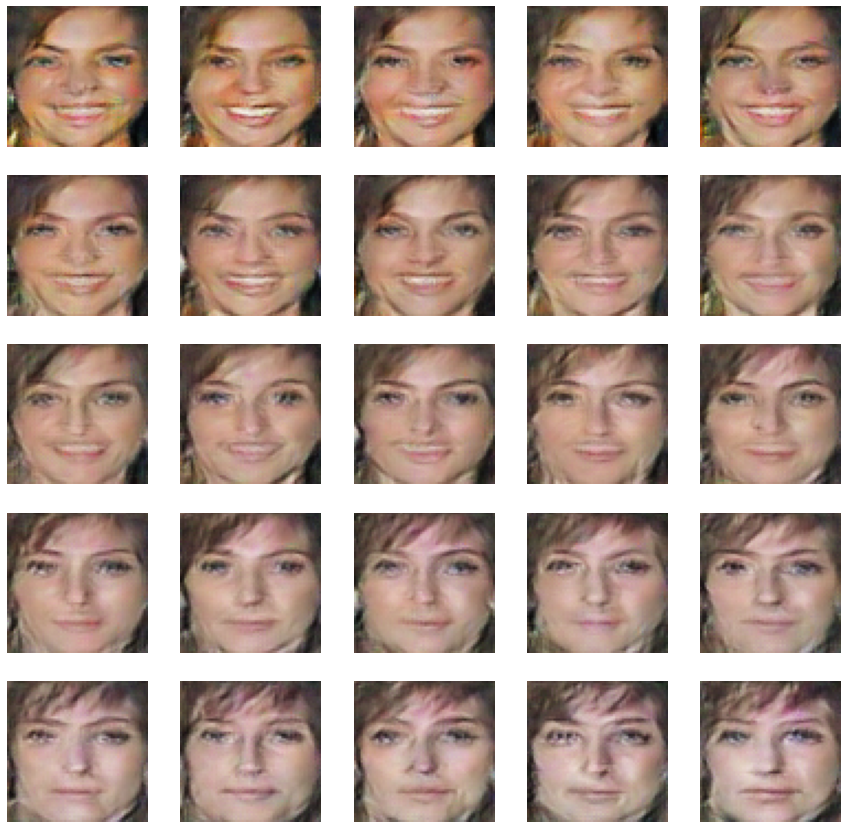

In [51]:
z1 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
with tf.Session() as sess:
    load(sess, "checkpoint")
    alpha = np.linspace(0., 1., BATCH_SIZE).reshape((-1,1))

    alpha = np.repeat(alpha, Z_DIM, axis=1)
    batch_z = z1*alpha + z2*(1-alpha)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    #save_images(samples, [MERGE_X, MERGE_Y], 'result.png')
    elements = np.linspace(0, 63, 25, dtype=np.int16)
    visualize(inverse_transform(samples[elements, :, :, :]), 5, 5)

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

INFO:tensorflow:Restoring parameters from checkpoint/dcgan-norm.model


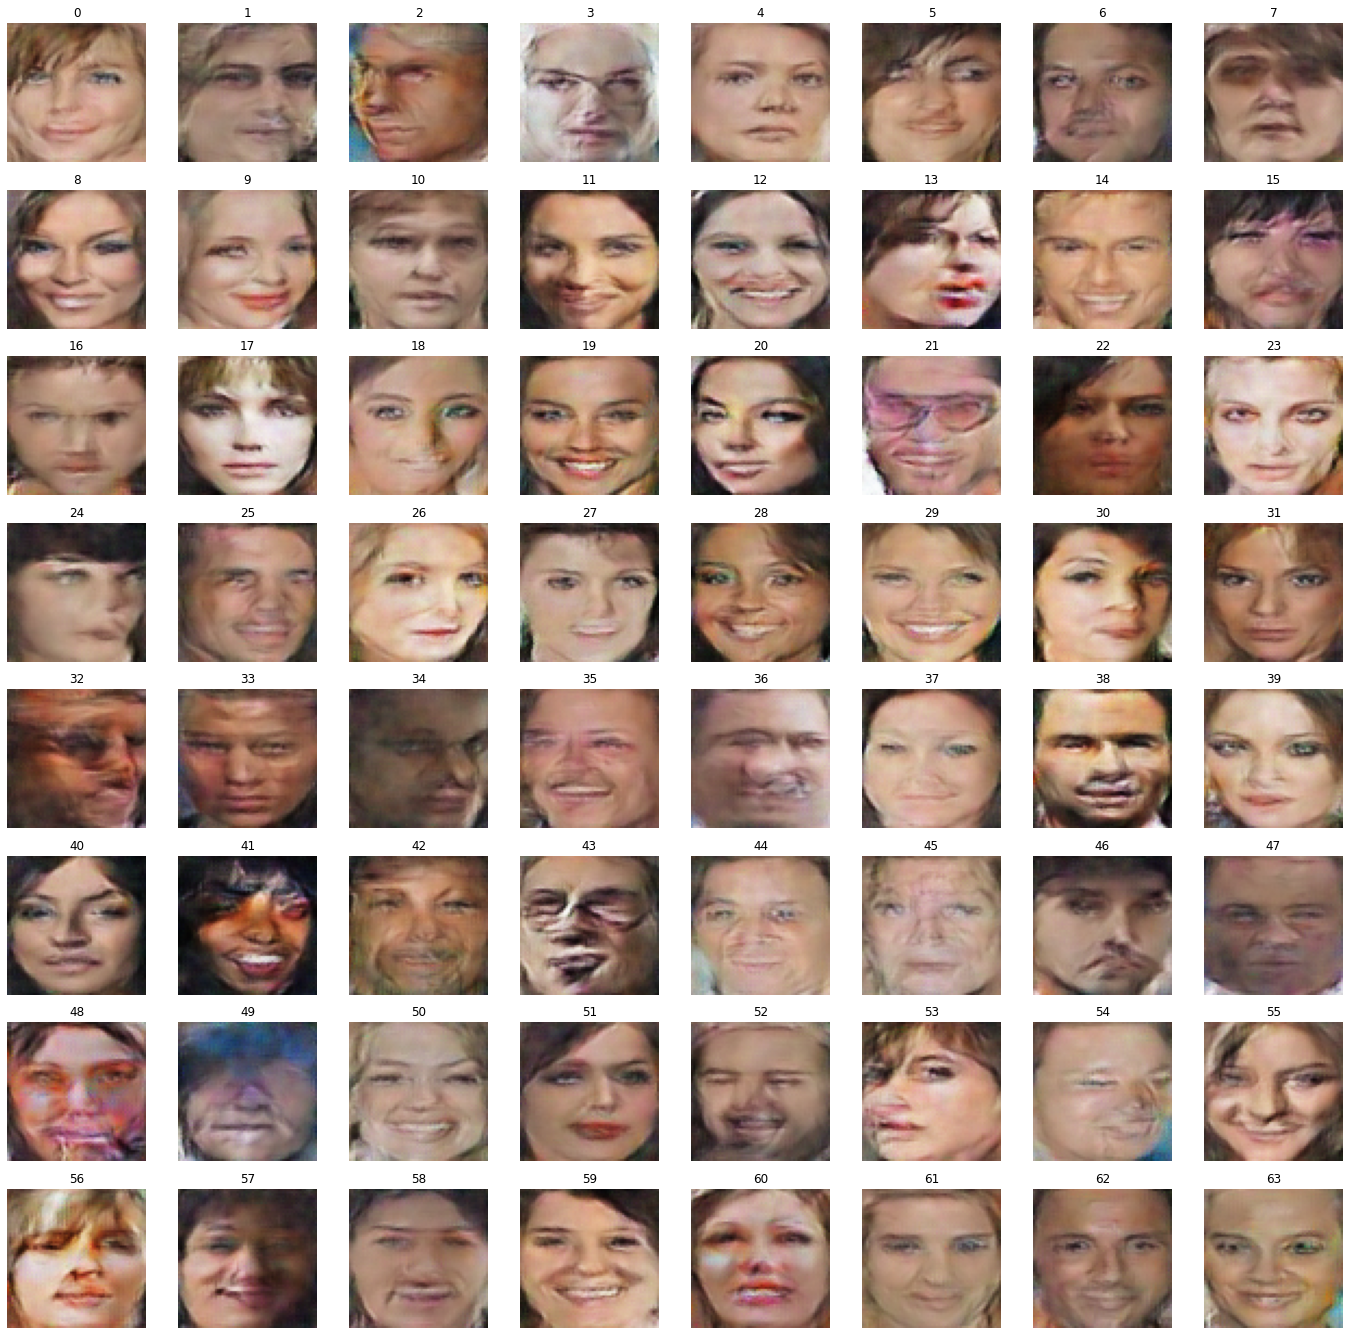

In [73]:
with tf.Session() as sess:
    load(sess, "checkpoint")
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    #save_images(samples, [MERGE_X, MERGE_Y], 'see_smiles.png')
    #elements = np.linspace(0, 6, 25, dtype=np.int16)
    visualize(inverse_transform(samples), MERGE_X, MERGE_Y)

In [74]:
smile_mean = np.mean([batch_z[19], batch_z[59], batch_z[28], batch_z[29], batch_z[12]], axis=0)
not_smile = np.mean([batch_z[17], batch_z[51], batch_z[31], batch_z[26], batch_z[4], batch_z[33]], axis=0)

In [85]:
with tf.Session() as sess:
    load(sess, "checkpoint")
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    batch_s = batch_z + (smile_mean-not_smile)
    samples_normal = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    #visualize(inverse_transform(samples), MERGE_X, MERGE_Y)
    samples_smile = sess.run(G, feed_dict={z: batch_s, is_training: False} )
    #visualize(inverse_transform(samples), MERGE_X, MERGE_Y)

INFO:tensorflow:Restoring parameters from checkpoint/dcgan-norm.model


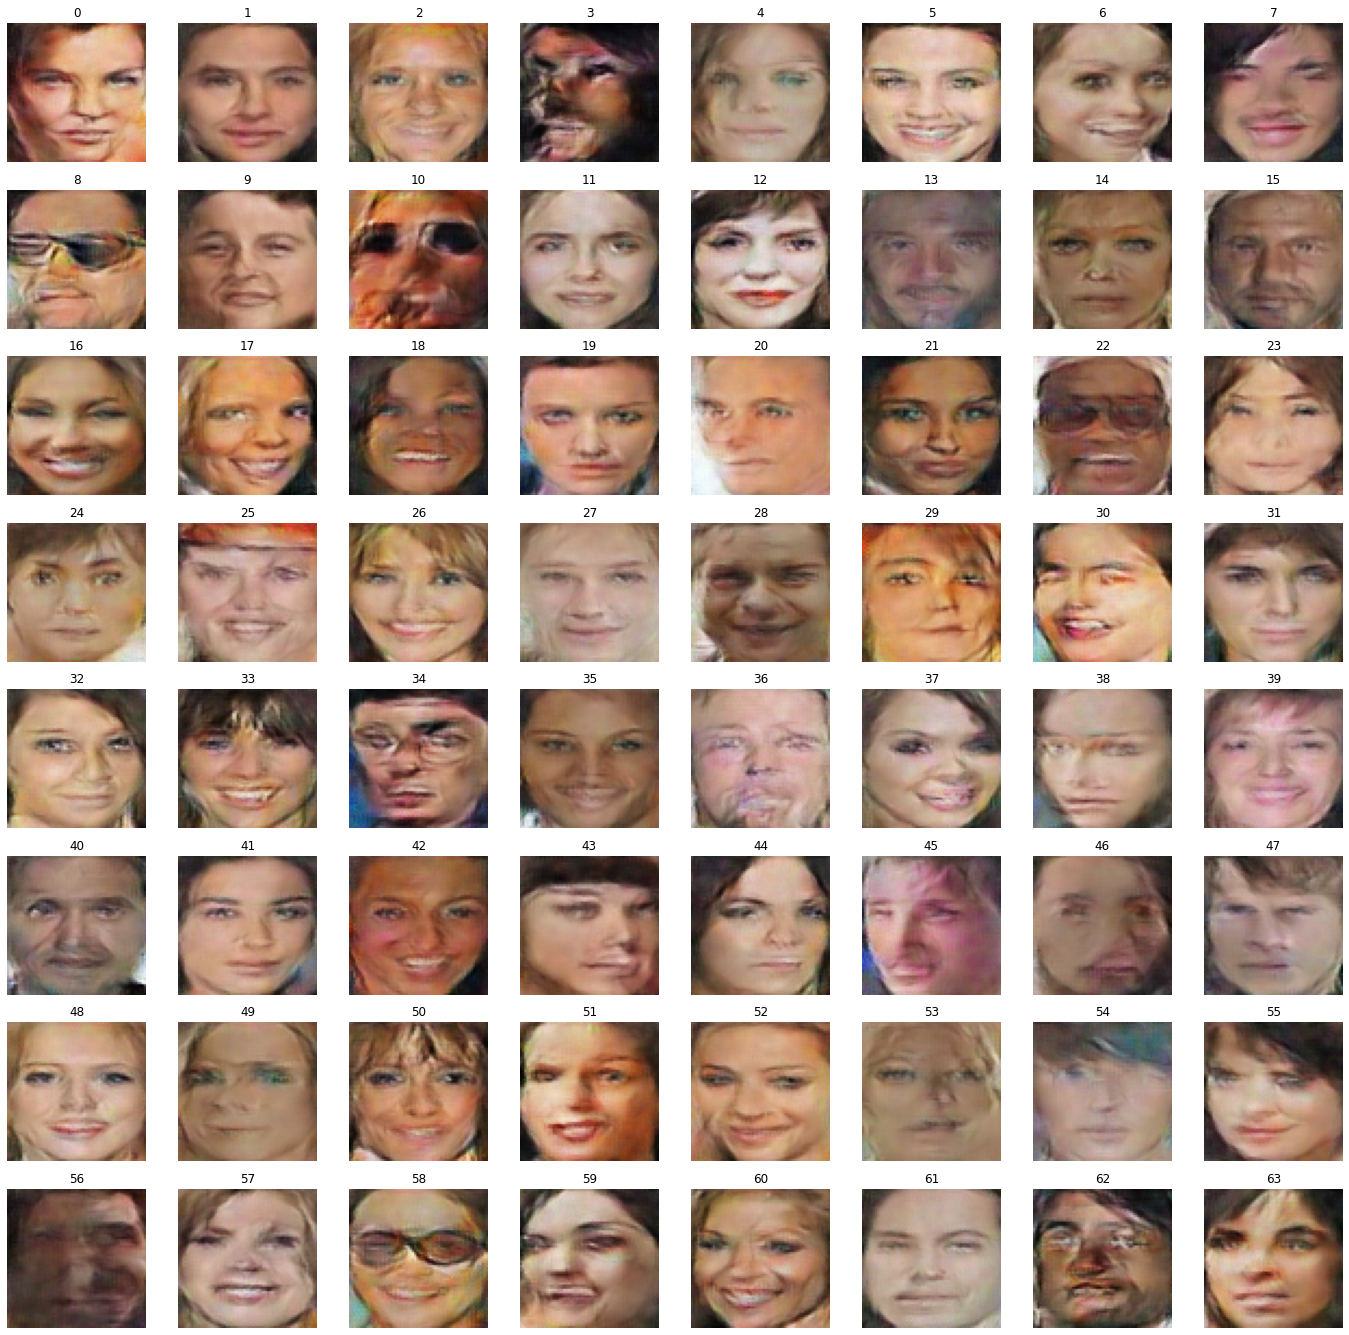

In [86]:
visualize(inverse_transform(samples_normal), MERGE_X, MERGE_Y)

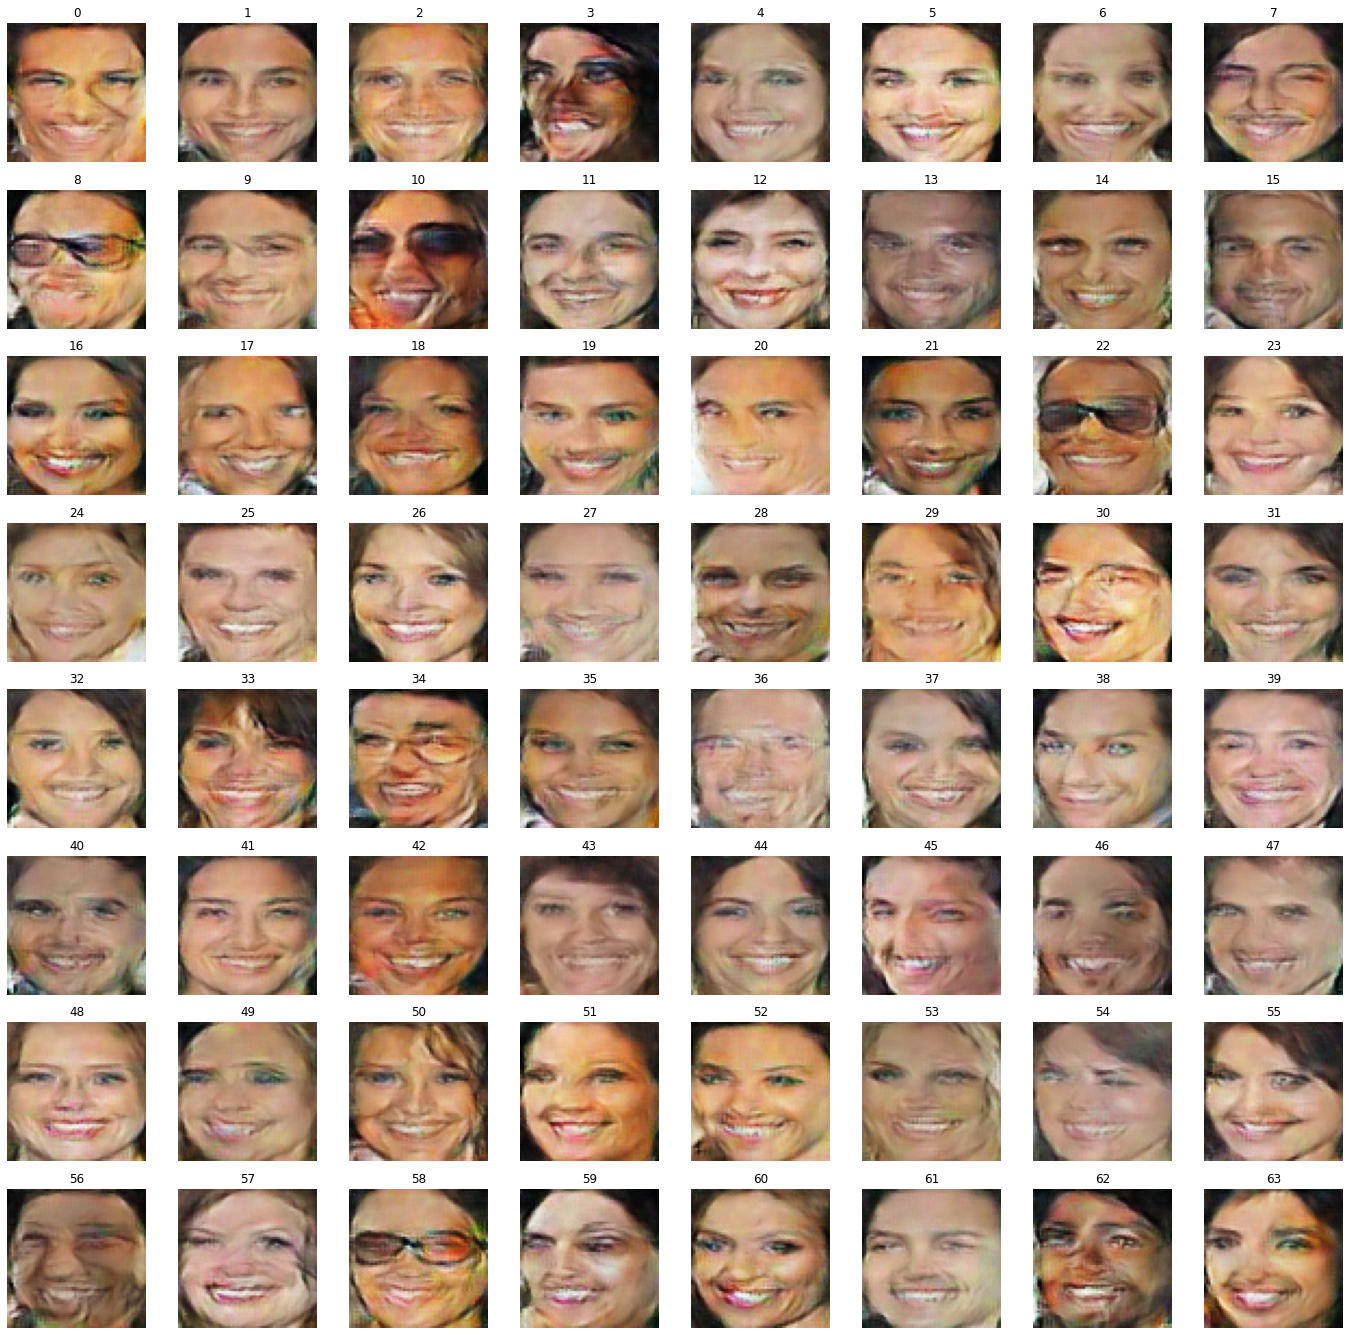

In [87]:
visualize(inverse_transform(samples_smile), MERGE_X, MERGE_Y)

If faces looks really cool, add bonus 1 point to your score.